# GF-KSD: Importance Sampling of a Lotka-Volterra Model (Figure 3)

In [2]:
import torch
from torch.distributions import MultivariateNormal
import numpy as np
from qpsolvers import solve_qp
import pandas

from steintorch.utils.get_score import get_score
from steintorch.kernel import LinearKernel
from steintorch.divergence.mmd import MMD
from steintorch.divergence.ksd import GradientFreeKSD, KSD

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from pylab import rcParams
rcParams['figure.figsize'] = 10,6

from matplotlib import cm

### Load in Data

In [3]:
dimension = 8

lotka_real = pandas.read_csv("data/lotka_stan_real.csv", usecols=[i+1 for i in range(2 * dimension + 1)])
lotka_laplace10 = pandas.read_csv("data/lotka_laplace10.csv", usecols=[i+1 for i in range(2 * dimension + 1)])
lotka_laplace15 = pandas.read_csv("data/lotka_laplace15.csv", usecols=[i+1 for i in range(2 * dimension + 1)])
lotka_laplace20 = pandas.read_csv("data/lotka_laplace20.csv", usecols=[i+1 for i in range(2 * dimension + 1)])
lotka_laplace25 = pandas.read_csv("data/lotka_laplace25.csv", usecols=[i+1 for i in range(2 * dimension + 1)])
lotka_laplace30 = pandas.read_csv("data/lotka_laplace30.csv", usecols=[i+1 for i in range(2 * dimension + 1)])
lotka_laplace35 = pandas.read_csv("data/lotka_laplace35.csv", usecols=[i+1 for i in range(2 * dimension + 1)])
lotka_laplace40 = pandas.read_csv("data/lotka_laplace40.csv", usecols=[i+1 for i in range(2 * dimension + 1)])

lotka_real_torch = torch.Tensor(lotka_real.values)
lotka_laplace10_torch = torch.Tensor(lotka_laplace10.values)
lotka_laplace15_torch = torch.Tensor(lotka_laplace15.values)
lotka_laplace20_torch = torch.Tensor(lotka_laplace20.values)
lotka_laplace25_torch = torch.Tensor(lotka_laplace25.values)
lotka_laplace30_torch = torch.Tensor(lotka_laplace30.values)
lotka_laplace35_torch = torch.Tensor(lotka_laplace35.values)
lotka_laplace40_torch = torch.Tensor(lotka_laplace40.values)

lotka_real_samples = lotka_real_torch.T[:dimension].T
lotka_real_scores = lotka_real_torch.T[dimension : 2 * dimension].T
lotka_real_log_probs = lotka_real_torch.T[2 * dimension].T

lotka_laplace10_samples = lotka_laplace10_torch.T[:dimension].T
lotka_laplace10_scores = lotka_laplace10_torch.T[dimension:2 * dimension].T
lotka_laplace10_log_probs = lotka_laplace10_torch.T[2 * dimension].T

lotka_laplace15_samples = lotka_laplace15_torch.T[:dimension].T
lotka_laplace15_scores = lotka_laplace15_torch.T[dimension:2 * dimension].T
lotka_laplace15_log_probs = lotka_laplace15_torch.T[2 * dimension].T

lotka_laplace20_samples = lotka_laplace20_torch.T[:dimension].T
lotka_laplace20_scores = lotka_laplace20_torch.T[dimension:2 * dimension].T
lotka_laplace20_log_probs = lotka_laplace20_torch.T[2 * dimension].T

lotka_laplace25_samples = lotka_laplace25_torch.T[:dimension].T
lotka_laplace25_scores = lotka_laplace25_torch.T[dimension:2 * dimension].T
lotka_laplace25_log_probs = lotka_laplace25_torch.T[2 * dimension].T

lotka_laplace30_samples = lotka_laplace30_torch.T[:dimension].T
lotka_laplace30_scores = lotka_laplace30_torch.T[dimension:2 * dimension].T
lotka_laplace30_log_probs = lotka_laplace30_torch.T[2 * dimension].T

lotka_laplace35_samples = lotka_laplace35_torch.T[:dimension].T
lotka_laplace35_scores = lotka_laplace35_torch.T[dimension:2 * dimension].T
lotka_laplace35_log_probs = lotka_laplace35_torch.T[2 * dimension].T

lotka_laplace40_samples = lotka_laplace40_torch.T[:dimension].T
lotka_laplace40_scores = lotka_laplace40_torch.T[dimension:2 * dimension].T
lotka_laplace40_log_probs = lotka_laplace40_torch.T[2 * dimension].T

### Defining $q$ for each Laplace approximation

In [5]:
from steintorch.utils.dist_approximations import get_gaussian_mixture_approximation

normal = get_gaussian_mixture_approximation(lotka_real_samples, N=1).component_distribution
new_norm = MultivariateNormal(normal.mean.flatten(), normal.covariance_matrix.squeeze())

In [6]:
hessian_pandas = pandas.read_csv("data/hessian.csv", usecols=[i+1 for i in range(dimension)])
hessian = torch.Tensor(hessian_pandas.values)

optimum = pandas.read_csv("data/optimal.csv", usecols=[1])

cov_matrix10 = torch.linalg.inv(-hessian) #torch.Tensor(np.loadtxt('foo.csv',delimiter=","))
cov_matrix15 = cov_matrix10 * 0.9
cov_matrix20 = cov_matrix10 * 1.05
cov_matrix25 = cov_matrix10 * 1.15
cov_matrix30 = cov_matrix10 * 1.2
cov_matrix35 = cov_matrix10 * 1.3
cov_matrix40 = cov_matrix10 * 1.4

mean_vector = torch.Tensor(optimum.values)

mvn_10 = MultivariateNormal(mean_vector.flatten(), cov_matrix10)
mvn_15 = MultivariateNormal(mean_vector.flatten(), cov_matrix15)
mvn_20 = MultivariateNormal(mean_vector.flatten(), cov_matrix20)
mvn_25 = MultivariateNormal(mean_vector.flatten(), cov_matrix25)
mvn_30 = MultivariateNormal(mean_vector.flatten(), cov_matrix30)
mvn_35 = MultivariateNormal(mean_vector.flatten(), cov_matrix35)
mvn_40 = MultivariateNormal(mean_vector.flatten(), cov_matrix40)


## Define GF-KSD and KSD

In [7]:
gf_KSD = GradientFreeKSD(None, preconditioner=torch.Tensor([1]))
_KSD = KSD(None, preconditioner=torch.Tensor([1]))

covariance = lotka_real_samples.T.cov()
linear_kernel = LinearKernel(dim=8, param_dict={"c": torch.Tensor([1]), "lengthscale": covariance})
# linear_kernel = LinearKernel(dim=6)
mmd_linear = MMD(linear_kernel)


## Define GF-KSD importance sampling and Self-Normalised Importance Sampling

We will use the data standardisation `standard_cov` which computes the standardisation $(C^{-1})^{1/2}$ where $C$ is the covariance matrix of the samples.

In [9]:
from steintorch.utils import nearestSPD
from steintorch.utils import standard_cov

In [10]:
def ksd_is(samples, p_evals, q_evals, q_scores, p_samples, mmd, p_scores=None, standardise_func=standard_cov, ksd=False):

    if standardise_func is not None:
        standardise_vec = standardise_func(samples)
        if standardise_vec.dim() < 2:
            add_const = torch.log(torch.prod(standardise_vec))

            tsamples = samples / standardise_vec
            tscores = q_scores * standardise_vec
            
            if p_scores is not None:
                tp_scores = p_scores * standardise_vec

            tp_evals = p_evals + add_const
            tq_evals = q_evals + add_const
        else:
            inverse_standard = torch.linalg.inv(standardise_vec)
            add_const = torch.slogdet(inverse_standard)[1]
            tsamples = torch.matmul(samples, standardise_vec)
            tscores = torch.matmul(q_scores, inverse_standard.T)

            if p_scores is not None:
                tp_scores = torch.matmul(p_scores, inverse_standard.T)

            tp_evals = p_evals + add_const
            tq_evals = q_evals + add_const
    else:
        tsamples = samples
        tscores = q_scores
        tp_evals = p_evals
        tq_evals = q_evals
        tp_scores = p_scores

    const = (tp_evals - tq_evals).min()
    ttp_evals = tp_evals - const - 12
    if ksd is False:
        ksd_mat = gf_KSD.stein_matrix(tsamples, ttp_evals, tq_evals, tscores).detach()
    else:
        ksd_mat = _KSD.stein_matrix(tsamples, tp_scores).detach()

    P = np.array(nearestSPD(ksd_mat / ksd_mat.sum()) * 5e8) 
    A = np.ones(P.shape[0])
    b = np.array([1]) 
    lb = np.zeros(P.shape[0])
    optim_weight = torch.Tensor(solve_qp(P, lb, None, None, A, b, lb, None, solver="scs",eps_abs=1e-07, eps_rel=1e-07))

    mmd_output = mmd.eval(x = samples, y = p_samples, weights_x = optim_weight.flatten())

    return optim_weight, mmd_output


In [11]:
def get_mmd_self_normalised(samples, p_evals, q_evals, p_samples, mmd):
    diff = (p_evals - q_evals).detach()
    diff = diff - diff.mean()
    self_normalised_weights = diff.exp() / diff.exp().sum()

    mmd_output = mmd.eval(x = samples, y = p_samples, weights_x = self_normalised_weights).detach()
    return self_normalised_weights, mmd_output

## Define Importance Sampling Experiment Function and Plotting Function

In [12]:
def is_experiment(q_samples, p_evals, q_evals, q_scores, random_samples, N_list, p_samples,
                  p_scores=None, mmd=mmd_linear, standardise_func=standard_cov, 
                print_progress=False):
                  
    N = len(N_list)
    M = len(random_samples)
    mmd_list = [[] for i in range(N)]
    mmd_norm_list = [[] for i in range(N)]

    for i in range(N):
        if print_progress is True:
            print(str(i) + '/' + str(N))
        for j in range(M):
            q_samples_ij = q_samples[random_samples[j]][:N_list[i]]
            q_evals_ij = q_evals[random_samples[j]][:N_list[i]]
            q_scores_ij = q_scores[random_samples[j]][:N_list[i]]
            p_evals_ij = p_evals[random_samples[j]][:N_list[i]]

            if p_scores is not None:
                p_scores_ij = p_scores[random_samples[j]][:N_list[i]]
                out = ksd_is(q_samples_ij, p_evals_ij, q_evals_ij, q_scores_ij, p_samples, mmd,
                             p_scores=p_scores_ij, standardise_func=standardise_func, ksd=True)
                mmd_list[i].append(out[1].detach())
            else:
                out = ksd_is(q_samples_ij, p_evals_ij, q_evals_ij, q_scores_ij, p_samples, mmd,
                             standardise_func=standardise_func)
                mmd_list[i].append(out[1].detach())

            out_norm = get_mmd_self_normalised(q_samples_ij, p_evals_ij, q_evals_ij, p_samples, mmd)
            mmd_norm_list[i].append(out_norm[1].detach())

    return(mmd_list, mmd_norm_list)

In [69]:
def plot_is_experiment(axis, mmd_list, mmd_norm_list, n_list, color, label, label2=None, color2=None, width=2.5):
    const = 1/math.sqrt(len(mmd_list[0]))
    x_axis = torch.log(torch.Tensor(n_list))

#
    mmd_tensor = torch.Tensor(mmd_list)
    mean = mmd_tensor.log().mean(dim=1)
    std = torch.log(mmd_tensor).std(dim=1)

    mmdnorm_tensor = torch.Tensor(mmd_norm_list)
    meannorm = mmdnorm_tensor.log().mean(dim=1)
    stdnorm = torch.log(mmdnorm_tensor).std(dim=1)

    axis.plot(x_axis, mean, color=color, label=label,linewidth=width)
    axis.fill_between(x_axis, mean - const * std, mean + const * std, color = color, alpha=0.2)
    if color2 is None:
        if label2 is None:
            axis.plot(x_axis, meannorm, linestyle='dotted',color=color,linewidth=width, dashes=[1.1, 1])
        else:
            axis.plot(x_axis, meannorm, linestyle='dotted',color=color,linewidth=width,label=label2, dashes=[1.1, 1])
        axis.fill_between(x_axis, meannorm - const * stdnorm, meannorm + const * stdnorm, color = color, alpha=0.2)
    else:
        if label2 is None:
            axis.plot(x_axis, meannorm, linestyle='dotted',color=color2,linewidth=width, dashes=[1.1, 1])
        else:
            axis.plot(x_axis, meannorm, linestyle='dotted',color=color2,linewidth=width,label=label2, dashes=[1.1, 1])
        axis.fill_between(x_axis, meannorm - const * stdnorm, meannorm + const * stdnorm, color = color2, alpha=0.2)

In [124]:
covariance = lotka_real_samples.T.cov()#p_samples.T.cov()
linear_kernel = LinearKernel(dim=2, param_dict={"c": torch.Tensor([1]), "lengthscale": covariance})
mmdnew = MMD(linear_kernel)

## Run Experiment:

In [14]:
import random
random_samples = []

for i in range(30):
    random_samples.append(random.sample(range(2000), 400))

N_list = [6 * (i + 2) for i in range(50)]

lotka_laplace10_evals = mvn_10.log_prob(lotka_laplace10_samples) 
q10_scores = get_score(lotka_laplace10_samples.requires_grad_(True), mvn_10).detach() # Q scores
mmd10, mmdnorm10 = is_experiment(lotka_laplace10_samples, lotka_laplace10_log_probs, lotka_laplace10_evals, q10_scores, random_samples, N_list, lotka_real_samples, p_scores=None, mmd=mmd_linear, print_progress=True)

lotka_laplace15_evals = mvn_15.log_prob(lotka_laplace15_samples) 
q15_scores = get_score(lotka_laplace15_samples.requires_grad_(True), mvn_15).detach() # Q scores
mmd15, mmdnorm15 = is_experiment(lotka_laplace15_samples, lotka_laplace15_log_probs, lotka_laplace15_evals, q15_scores, random_samples, N_list, lotka_real_samples, p_scores=None,mmd=mmd_linear, print_progress=True)

lotka_laplace20_evals = mvn_20.log_prob(lotka_laplace20_samples) 
q20_scores = get_score(lotka_laplace20_samples.requires_grad_(True), mvn_20).detach() # Q scores
mmd20, mmdnorm20 = is_experiment(lotka_laplace20_samples, lotka_laplace20_log_probs, lotka_laplace20_evals, q20_scores, random_samples, N_list, lotka_real_samples, p_scores=None,mmd=mmd_linear, print_progress=True)

lotka_laplace25_evals = mvn_25.log_prob(lotka_laplace25_samples) 
q25_scores = get_score(lotka_laplace25_samples.requires_grad_(True), mvn_25).detach() # Q scores
mmd25, mmdnorm25 = is_experiment(lotka_laplace25_samples, lotka_laplace25_log_probs, lotka_laplace25_evals, q25_scores, random_samples, N_list, lotka_real_samples,p_scores=None,mmd=mmd_linear, print_progress=True)

lotka_laplace30_evals = mvn_30.log_prob(lotka_laplace30_samples) 
q30_scores = get_score(lotka_laplace30_samples.requires_grad_(True), mvn_30).detach() # Q scores
mmd30, mmdnorm30 = is_experiment(lotka_laplace30_samples, lotka_laplace30_log_probs, lotka_laplace30_evals, q30_scores, random_samples, N_list, lotka_real_samples,p_scores=None,mmd=mmd_linear, print_progress=True)

lotka_laplace35_evals = mvn_35.log_prob(lotka_laplace35_samples) 
q35_scores = get_score(lotka_laplace35_samples.requires_grad_(True), mvn_35).detach() # Q scores
mmd35, mmdnorm35 = is_experiment(lotka_laplace35_samples, lotka_laplace35_log_probs, lotka_laplace35_evals, q35_scores, random_samples, N_list, lotka_real_samples,p_scores=None, mmd=mmd_linear, print_progress=True)

lotka_laplace40_evals = mvn_40.log_prob(lotka_laplace40_samples) 
q40_scores = get_score(lotka_laplace40_samples.requires_grad_(True), mvn_40).detach() # Q scores
mmd40, mmdnorm40 = is_experiment(lotka_laplace40_samples, lotka_laplace40_log_probs, lotka_laplace40_evals, q40_scores, random_samples, N_list, lotka_real_samples,p_scores=None,mmd=mmd_linear, print_progress=True)


0/50


/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/pystein-0.0.0-py3.9.egg/pystein/utils/helper.py:70: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)
  _ = torch.cholesky(B)
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packa

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
2

/var/folders/y9/f2jq2rkn6h16kl4g9j02c2800000gn/T/ipykernel_33376/1508102187.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("fig_3b.pdf", bbox_inches = "tight", padding = 0)


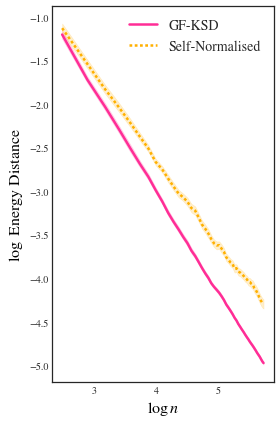

In [72]:
import math 

style.use("seaborn-white")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# color_cycle = cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = ['#FF2D96','#FFB000','#648FFF']
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(4, 6))

plot_is_experiment(axis, mmd10, mmdnorm10, N_list, color_cycle[0], 'GF-KSD', label2='Self-Normalised', color2=color_cycle[1])
# plot_is_experiment(axis, mmd20, mmdnorm20, N_list, color_cycle[1], '$\\lambda = 1.05$', width=3)
# plot_is_experiment(axis, mmd15, mmdnorm10, N_list, color_cycle[2], '$\\lambda = 1.1$')
# plot_is_experiment(axis, mmd25, mmdnorm25, N_list, color_cycle[2], '$\\lambda = 1.15$', width=3)
# plot_is_experiment(axis, mmd30, mmdnorm30, N_list, color_cycle[4], '$\\lambda = 1.2$')
# plot_is_experiment(axis, mmd35, mmdnorm35, N_list, color_cycle[5], '$\\lambda = 1.3$')
# plot_is_experiment(axis, mmd40, mmdnorm40, N_list, color_cycle[6], '$\\lambda = 1.4$')

axis.set_ylabel('$\log$ Energy Distance', fontsize = 16, fontweight=100, color='black')
axis.set_xlabel('$\log n$', fontsize = 16, fontweight=100, color='black')

axis.legend(loc=1, fontsize=14)
fig.tight_layout()
fig.savefig("fig_3b.pdf", bbox_inches = "tight", padding = 0)


## Plot Output

In [28]:
import seaborn as sns

In [ ]:
nn = 20
LL = [random.sample(range(2000), nn)]

q_samples = lotka_laplace10_samples[LL]
q_evals = lotka_laplace10_evals[LL]
q_scores = q10_scores[LL]
p_evals = lotka_laplace10_log_probs[LL]
p_scores = lotka_laplace10_scores[LL]

weights, mmd = ksd_is(q_samples, p_evals, q_evals, q_scores, lotka_real_samples, mmd_linear)
weights_standard = torch.ones(nn) / nn

/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

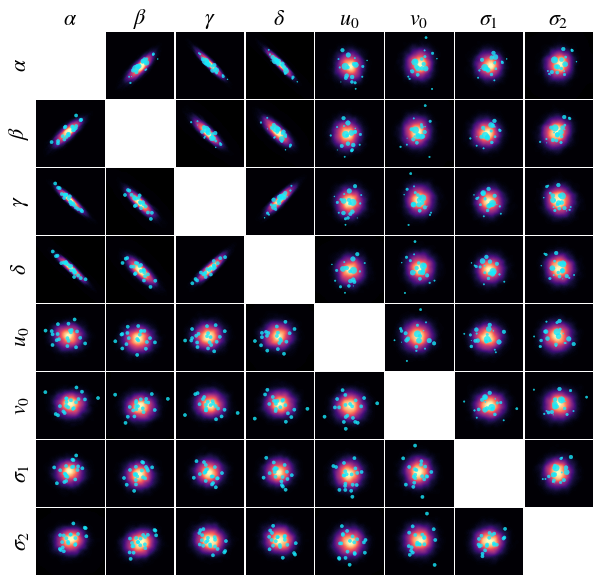

In [243]:
fig, axes = plt.subplots(ncols=dimension, nrows=dimension, figsize=(10, 10))

# left-hand plot:
style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

labels = ['$\\alpha$','$\\beta$','$\gamma$','$\delta$', '$u_0$','$v_0$' ,'$\sigma_{1}$','$\sigma_{2}$']

for i in range(dimension):
    for j in range(dimension):
        ax = axes[i, j]
        ax.set_rasterization_zorder(2)

for i in range(dimension):
    # axes[i, i].set_visible(False)
    axes[i,i].xaxis.set_ticks([])
    axes[i,i].yaxis.set_ticks([])
    axes[i,i].spines['top'].set_visible(False)
    axes[i,i].spines['right'].set_visible(False)
    axes[i,i].spines['bottom'].set_visible(False)
    axes[i,i].spines['left'].set_visible(False)
    axes[i,i].set_facecolor('white')
    axes[i, 0].set_ylabel(labels[i], fontsize = 22, fontweight=100, color='black')
    axes[0, i].set_title(labels[i], fontsize = 22, fontweight=100, color='black')


for i in range(dimension-1):
    for j in range(i,dimension-1):

        x = lotka_real_samples.T[i].numpy()
        y = lotka_real_samples.T[j+1].numpy()

        x_samps = q_samples.T[i].detach().numpy()
        y_samps = q_samples.T[j+1].detach().numpy()

        xmin =  x.min()
        xmax = x.max()
        ymin = y.min()
        ymax =  y.max()

        xxx = torch.linspace(xmin, xmax, 200)
        yyy = torch.linspace(ymin, ymax, 200)
        xgrid, ygrid = torch.meshgrid(xxx, yyy)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        ax = axes[i, j + 1]
        sns.kdeplot(x, y, fill=True, cmap='magma', thresh=0, ax=ax, zorder=1, levels=100)
        # ax.hexbin(x, y, gridsize=40, cmap='magma', rasterized=True)
        ax.scatter(x_samps, y_samps, s = weights.detach().pow(2) / weights.detach().pow(2).sum() * 200, color='#17e9fc', alpha=0.8, zorder=3)
        ax.set_facecolor('#000000')

        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

        x_left = lotka_real_samples.T[dimension-1-i].numpy()
        y_left = lotka_real_samples.T[dimension-2-j].numpy()

        x_samps_left = q_samples.T[dimension-1-i].detach().numpy()
        y_samps_left = q_samples.T[dimension-2-j].detach().numpy()

        ax_left = axes[dimension-1 - i, dimension - 2- j]
        sns.kdeplot(x_left, y_left, fill=True, cmap='magma', thresh=0, ax=ax_left, zorder=1, levels=100)
        # ax_left.hexbin(x_left, y_left, gridsize=40, cmap='magma', rasterized=True)#, bins='log')
        ax_left.scatter(x_samps_left, y_samps_left, s = weights_standard.detach() * 200, color='#17e9fc', alpha=0.8, zorder=3)        
        ax_left.xaxis.set_ticks([])
        ax_left.yaxis.set_ticks([])

        ax_left.set_facecolor('#000000')

fig.subplots_adjust(wspace=0.005, hspace=0.005)
fig.savefig("fig_3a_final.pdf", bbox_inches = "tight", padding = 0)